In [2]:
using Pkg
Pkg.activate("../")
using Axions
using Base.Threads
using PyPlot #to do plots 
using Unitful # units
using Unitful: Length, Energy, BField, Frequency, Mass, Time
using UnitfulAstro
using ProgressMeter
using PyCall
using Interpolations
using JLD2

  Activating project at `/lustre/ific.uv.es/ml/ific088/github/Axions.jl`


In [4]:
miri_old = load("/lhome/ific/a/aamerio/data/github/Axions.jl/src/data/JWST/bk/miri.jld2")
miri_new = load("/lhome/ific/a/aamerio/data/github/Axions.jl/src/data/JWST/miri.jld2")

Dict{String, Any} with 13 entries:
  "target_name" => ["NGC 1808", "NGC 1808", "NGC 1808", "NGC 1808", "NGC 1808",…
  "time"        => ["09:23:16.794", "10:53:00.469", "10:08:08.632", "09:23:16.2…
  "blanksky"    => [[123.521, 115.271, 115.516, 120.748, 121.833, 126.665, 125.…
  "b"           => [-0.626598, -0.626598, -0.626598, -0.626598, -0.626598, -0.6…
  "fits_name"   => ["jw06138-c1009_t003_miri_ch1-short_x1d.fits", "jw06138-c100…
  "DEC"         => [-37.5131, -37.5131, -37.5131, -37.5131, -37.5131, -37.5131,…
  "duration"    => [2009.13, 2009.13, 2009.13, 2009.13, 2009.13, 2009.13, 2009.…
  "RA"          => [76.9267, 76.9267, 76.9267, 76.9267, 76.9267, 76.9267, 76.92…
  "error"       => [[0.604409, 0.597502, 0.600201, 0.611658, 0.625489, 0.638934…
  "l"           => [4.20994, 4.20994, 4.20994, 4.20994, 4.20994, 4.20994, 4.209…
  "date"        => ["2025-01-18", "2025-01-18", "2025-01-18", "2025-01-18", "20…
  "is_bkd"      => [0, 0, 0, 0, 0, 0, 0, 0, 0, 0  …  0, 0, 0, 0, 0, 0, 0, 

In [7]:
fits_name_old = miri_old["fits_name"]
fits_name_new = miri_new["fits_name"]

18677-element Vector{String}:
 "jw06138-c1009_t003_miri_ch1-short_x1d.fits"
 "jw06138-c1009_t003_miri_ch1-long_x1d.fits"
 "jw06138-c1009_t003_miri_ch1-medium_x1d.fits"
 "jw06138-c1009_t003_miri_ch3-short_x1d.fits"
 "jw06138-c1009_t003_miri_ch3-long_x1d.fits"
 "jw06138-c1009_t003_miri_ch3-medium_x1d.fits"
 "jw06138-c1009_t003_miri_ch4-short_x1d.fits"
 "jw06138-c1009_t003_miri_ch4-long_x1d.fits"
 "jw06138-c1009_t003_miri_ch4-medium_x1d.fits"
 "jw06138-c1009_t003_miri_ch2-medium_x1d.fits"
 ⋮
 "jw04498-c1004_t008_miri_ch3-medium_x1d.fits"
 "jw04498-c1004_t008_miri_ch3-long_x1d.fits"
 "jw04498-c1004_t008_miri_ch3-short_x1d.fits"
 "jw04498-c1004_t008_miri_ch2-short_x1d.fits"
 "jw04498-c1004_t008_miri_ch2-medium_x1d.fits"
 "jw04498-c1004_t008_miri_ch2-long_x1d.fits"
 "jw04498-c1004_t008_miri_ch4-short_x1d.fits"
 "jw04498-c1004_t008_miri_ch4-long_x1d.fits"
 "jw04498-c1004_t008_miri_ch4-medium_x1d.fits"

In [10]:
common_files = intersect(fits_name_old, fits_name_new)

542-element Vector{String}:
 "jw01189-c1001_t001_miri_p750l_x1d.fits"
 "jw01189-o002_t001_miri_p750l_x1d.fits"
 "jw01189-o019_t008_miri_p750l_x1d.fits"
 "jw01240-c1000_t008_miri_p750l_x1d.fits"
 "jw01240-c1001_t002_miri_p750l_x1d.fits"
 "jw01240-c1002_t003_miri_p750l_x1d.fits"
 "jw01240-o001_t008_miri_p750l_x1d.fits"
 "jw01240-o003_t002_miri_p750l_x1d.fits"
 "jw01240-o005_t003_miri_p750l_x1d.fits"
 "jw01246-o051_t004_miri_ch1-short_x1d.fits"
 ⋮
 "jw04486-o002_t002_miri_ch3-short_x1d.fits"
 "jw04486-o002_t002_miri_ch4-short_x1d.fits"
 "jw04491-o003_t003_miri_p750l_x1d.fits"
 "jw04491-o004_t004_miri_p750l_x1d.fits"
 "jw04496-o015_t006_miri_p750l_x1d.fits"
 "jw04520-o004_t001_miri_p750l_x1d.fits"
 "jw04522-c1000_t001_miri_p750l_x1d.fits"
 "jw04522-o002_t001_miri_p750l_x1d.fits"
 "jw04575-o011_t001_miri_p750l_x1d.fits"

In [64]:
# 42, 100, 200, 250

obs_name = common_files[42]
print(obs_name)
idx_old = findfirst(isequal(obs_name), fits_name_old)
idx_new = findfirst(isequal(obs_name), fits_name_new)

flux_old = miri_old["blanksky"][idx_old]
flux_new = miri_new["blanksky"][idx_new]
flux_err_old = miri_old["error"][idx_old]
flux_err_new = miri_new["error"][idx_new]
;

jw01282-o032_t064_miri_ch1-short_x1d.fits

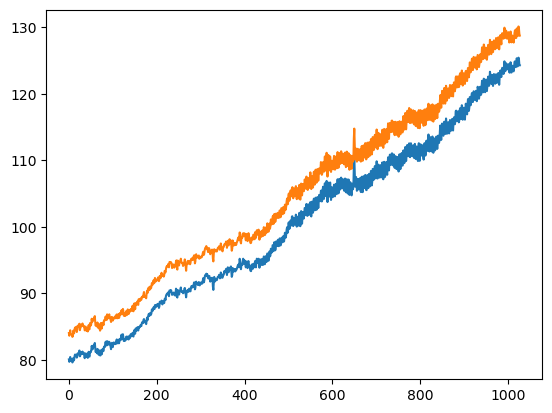

In [61]:
plt.clf()
plt.plot(flux_old, label="old")
plt.plot(flux_new, label="new")
plt.gcf()

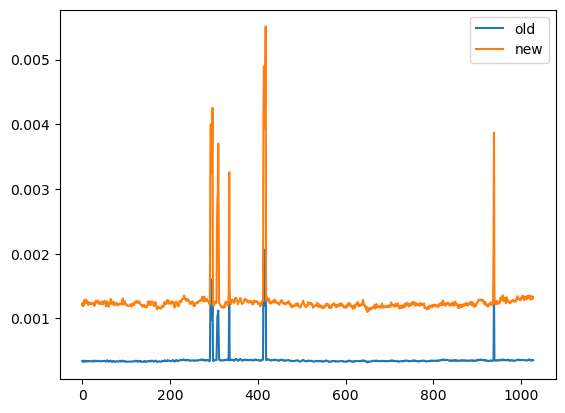

In [62]:
plt.clf()
plt.plot(flux_err_old./flux_old, label="old")
plt.plot(flux_err_new./flux_new, label="new")
plt.legend()
# plt.ylim(0,0.1)
plt.gcf()

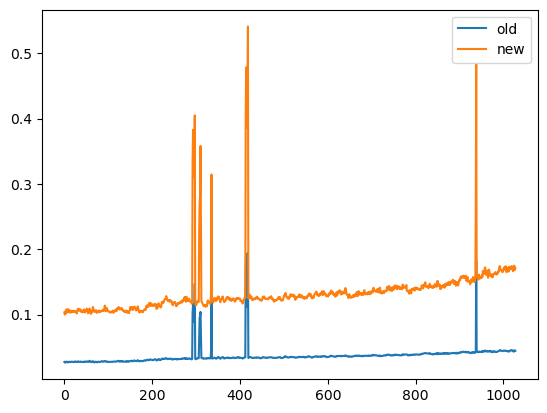

In [63]:
plt.clf()
plt.plot(flux_err_old, label="old")
plt.plot(flux_err_new, label="new")
plt.legend()
# plt.ylim(0,0.1)
plt.gcf()